In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [3]:
df_test.tail(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
409,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
411,1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
df_train.dtypes[df_train.dtypes.map(lambda x: x== 'object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

# Data Prep

In [7]:
# Have a 'result' DataFrame ready for prediction later.
result = pd.DataFrame({"PassengerId": df_test['PassengerId']})

In [8]:
# Cleaning train and test set, identify columns to encode/scale.

col_to_encode = ['Sex', 'Embarked']
col_to_scale = ['Age', 'Fare']

for c in col_to_encode:
    df_train[c].fillna('U', inplace=True)
    df_test[c].fillna('U', inplace=True)
    
for s in col_to_scale:
    # Coerce values into numeric
    df_train[s] = pd.to_numeric(df_train[s], errors='coerce')
    df_test[s] = pd.to_numeric(df_test[s], errors='coerce')
    # Fill in blank ones
    df_train[s].fillna(0.0, inplace=True)
    df_test[s].fillna(0.0, inplace=True)

# Fit the encoders from a combination of training and test data.
combined_df = df_train.append(df_test, ignore_index=True)

In [9]:
# Extract 'Title' from names and add an encoder for it.

def extract_titles(input_df):
    '''
    Extract titles from the 'Name' column in the input dataframe.
    
    Returns:
        list: A list of extracted titles
    '''
    names = [name.split(',')[1] for name in input_df['Name'].as_matrix()]
    return [name.split('.')[0].strip() for name in names]

col_to_encode.append('Title')
combined_df['Title'] = extract_titles(combined_df)
combined_df['Title'].fillna('U', inplace=True)

In [10]:
# Fitting encoders to take on numeric values.
from sklearn.preprocessing import LabelEncoder

# Need to fit the encoders separately for predictions later!
encoders = { c: LabelEncoder() for c in col_to_encode }
for c, e in encoders.items():
    e.fit(combined_df[c].as_matrix())
    #print({c}: {e.classes_})

In [11]:
# Fitting scalers for continuous values to between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scalers = { c: MinMaxScaler() for c in col_to_scale }
for c, s in scalers.items():
    s.fit(combined_df[c].as_matrix().reshape(-1, 1))

In [12]:
def transform_data(input_df):
    '''
    Transform the input DataFrame into a format that can be used for training as well as prediction.
    
    Returns:
        pandas.DataFrame: A copy of dataframe with transformed data.
    '''
    df = input_df.copy()
    
    # ==============================
    # Creating features
    # ==============================
    # HasCabin if 'Cabin' contain a string instead of NaN.
    df['HasCabin'] = [1 if isinstance(c, str) else 0 for c in df['Cabin'].as_matrix()]
    # HasRelatives if 'SibSp' + 'Parch' > 0
    df['HasRelatives'] = [int(i[0]+i[1]>0) for i in zip(df['SibSp'].as_matrix(), df['Parch'].as_matrix())]
    # Get titles
    df['Title'] = extract_titles(df)
    
    # ==============================
    # Encode columns
    # ==============================
    for c, e in encoders.items():
        df[c] = e.transform(df[c].as_matrix())

    # ==============================
    # Scale columns
    # ==============================
    for c, s in scalers.items():
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c].fillna(0.0, inplace=True)
        df[c] = s.transform(df[c].as_matrix().reshape(-1, 1))
        #df[c] = round(df[c], 3)
        
    col_to_drop = ['PassengerId','Name', 'Ticket', 'Cabin']
    return df.drop(col_to_drop, axis=1)

In [13]:
def get_targets(input_df):
    '''
    Split the data into features and labels.
    
    Returns:
        tuple: (X, y) where X contains the features and y contains labals.
    '''
    X = input_df.drop(['Survived'], axis=1).as_matrix()
    y = input_df['Survived'].as_matrix()
    return X, y

In [14]:
from sklearn.model_selection import train_test_split

def split_data(features, labels, include_val=False):
    '''
    Split the input dataframe into train and test sets of ratio 60/40. If include_val is set to True, 
    The ratio between train, val, and test sets are 60/20/20.
    
    Args:
        features (2D list): a list of features.
        labels(1D list): a list of labels.
        include_val(bool, optional): Whether to include validation set.
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test) if no validation set is generated, 
                otherwise (X_train, X_val, X_test, y_train, y_val, y_test)
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)
    
    if include_val:
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [15]:
transformed_df = transform_data(df_train)
X, y = get_targets(transformed_df)
X_train, X_test, y_train, y_test = split_data(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((534, 10), (357, 10), (534,), (357,))


# Model Training

In [16]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print "Accuracy is: %s" %round(score*100, 2) + " %"

Accuracy is: 85.43 %


# Predict Test Set

In [17]:
test_data = transform_data(df_test).as_matrix()
result['Survived'] = model.predict(test_data)
result.to_csv('./output.csv', index=False)

## Neural network classification

In [18]:
y = y.reshape(891,1)
test = np.array([y, -(y-1)]).T
y = test[0] # create two classes for the output
X_train, X_test, y_train, y_test = split_data(X, y)

In [19]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 1000
batch_size = 64

# Network parameters
n_hidden_1 = 10 # first layer
n_hidden_2 = 10 # second layer
n_input = X_train.shape[1] # number of features
n_class = 2 # number of classes

def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [None, n_x])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X,Y

def initialize_parameters():
    W1 = tf.Variable(tf.random_normal([n_input, n_hidden_1]))
    b1 = tf.Variable(tf.random_normal([n_hidden_1]))
    W2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
    b2 = tf.Variable(tf.random_normal([n_hidden_2]))
    W3 = tf.Variable(tf.random_normal([n_hidden_2, n_class]))
    b3 = tf.Variable(tf.random_normal([n_class]))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

def forward_propagation(x, parameters):
    # Hidden layers with RELU activation
    z1 = tf.add(tf.matmul(x, parameters["W1"]), parameters["b1"])
    a1 = tf.nn.relu(z1)
    
    # Hidden layers with RELU activation
    z2 = tf.add(tf.matmul(a1, parameters["W2"]), parameters["b2"])
    a2 = tf.nn.relu(z2)
    
    # Ouput layer with linear activation
    z3 = tf.add(tf.matmul(a2, parameters["W3"]), parameters["b3"])
    return z3

In [20]:
def titanic_model(X_train, y_train, X_test, y_test, learning_rate = learning_rate,
                 num_epochs = num_epochs, batch_size = batch_size):
    tf.set_random_seed(1)
    (m, n_x) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = y_train.shape[1]
    costs = []
    
    x_nn, y_nn = create_placeholders(n_x, n_y)
    
    parameters = initialize_parameters()
    
    z3 = forward_propagation(x_nn, parameters)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = z3, labels = y_nn))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(len(X_train) / batch_size)
            X_batches = np.array_split(X_train, num_minibatches)
            Y_batches = np.array_split(y_train, num_minibatches)
        
            for i in range(num_minibatches):
                batch_x, batch_y = X_batches[i], Y_batches[i]
            
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {x_nn: batch_x, y_nn: batch_y})
                    
                epoch_cost += minibatch_cost / num_minibatches
            
            if epoch % 100 == 0:
                print "Cost after epoch %i: %f" % (epoch, epoch_cost)
            if epoch % 5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        parameters = sess.run(parameters)
        print "Parameters have been trained!"
    
        correct_prediction = tf.equal(tf.argmax(z3, 1), tf.argmax(y_nn, 1))
    
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
        print "Train accuracy:" , accuracy.eval({x_nn: X_train, y_nn: y_train})
        print "Test accuracy:", accuracy.eval({x_nn: X_test, y_nn: y_test})
        
        return parameters

Cost after epoch 0: 7.598319
Cost after epoch 100: 0.611981
Cost after epoch 200: 0.457291
Cost after epoch 300: 0.397404
Cost after epoch 400: 0.387429
Cost after epoch 500: 0.377096
Cost after epoch 600: 0.370885
Cost after epoch 700: 0.367965
Cost after epoch 800: 0.366430
Cost after epoch 900: 0.364373


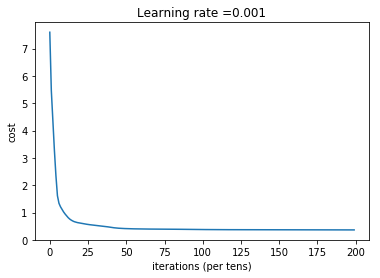

Parameters have been trained!
Train accuracy: 0.838951
Test accuracy: 0.759104


In [21]:
parameters = titanic_model(X_train, y_train, X_test, y_test)

In [22]:
test_data_float32 = test_data.astype('float32')
x_nn_predict = tf.placeholder(tf.float32, [None, test_data_float32.shape[1]])

z3_predict = forward_propagation(x_nn_predict, parameters)
p = tf.argmax(z3_predict, 1)

sess = tf.Session()
prediction = sess.run(p, feed_dict =  {x_nn_predict: test_data_float32})

result_nn = pd.DataFrame({"PassengerId": df_test['PassengerId']})
result_nn['Survived'] = model.predict(test_data)
result_nn.to_csv('./output_nn.csv', index=False)